## Crime forecasting with NeuralProphet - using weather data, additional regressors and optimized parameters.

1. Importing libraries

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from neuralprophet import utils
import random
import torch
from neuralprophet import set_random_seed

seed = 42
utils.set_random_seed(seed=42)
set_random_seed(seed=42)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)  
random.seed(seed)
torch.manual_seed(seed)

2. Importing daily crime count with weather data.

Memory usage of dataframe is 0.33 MB
Memory usage after optimizations: 0.07 MB
Decreased by 77.6%


<Axes: xlabel='ds'>

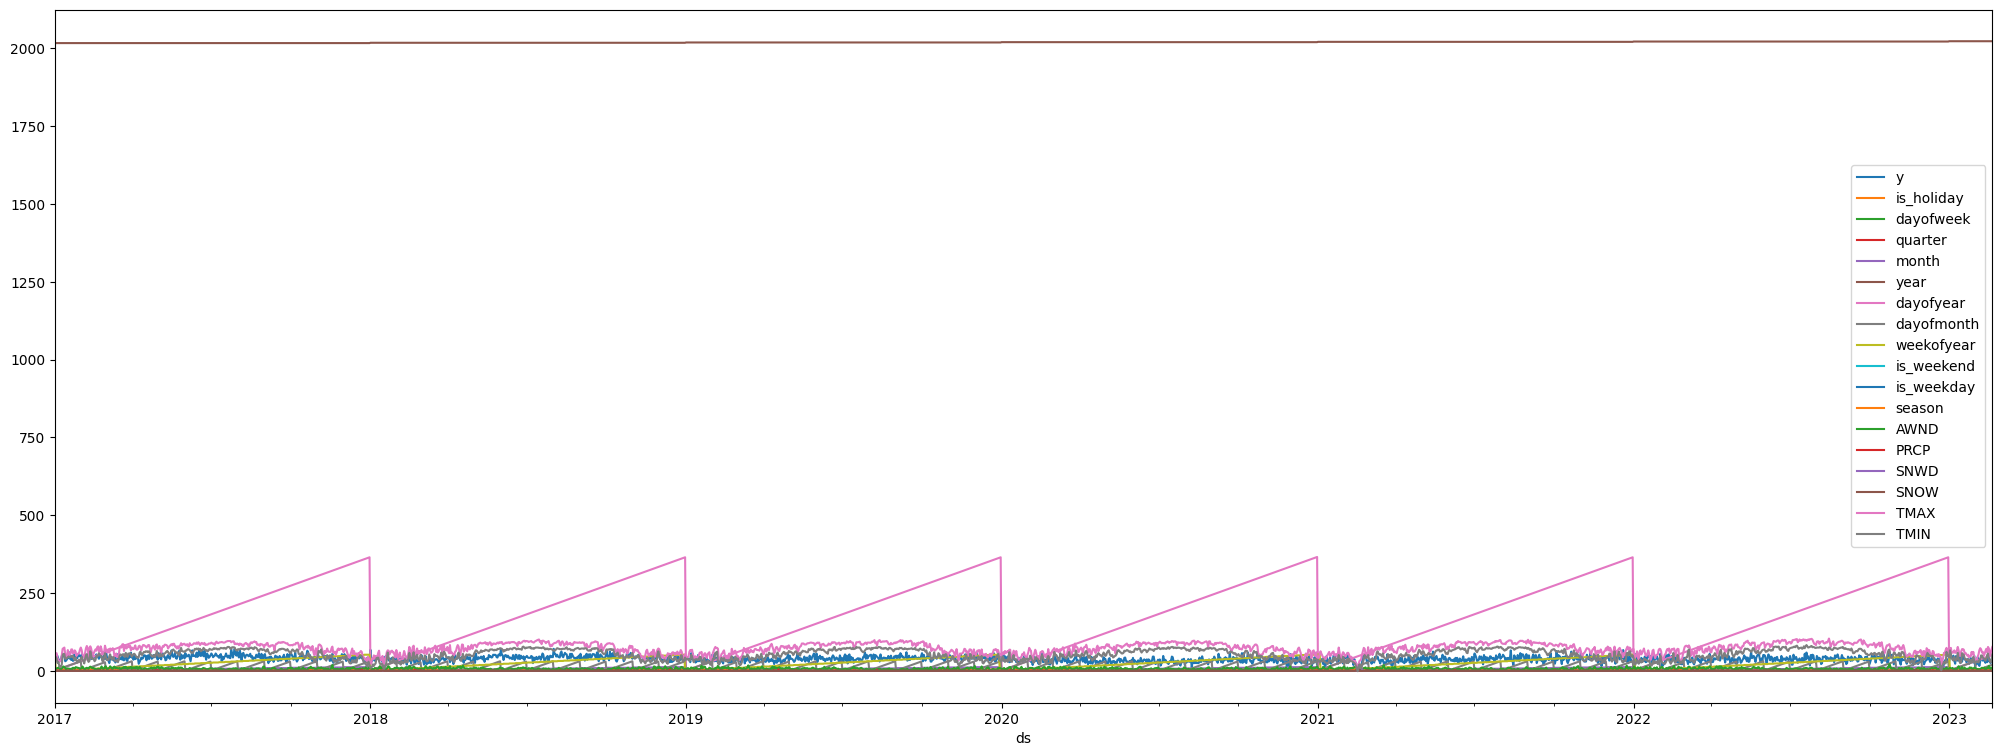

In [2]:
df = pd.read_csv("../../../data/final-lrpd-data.csv")
import reduce_mem_usage
df = reduce_mem_usage.reduce_mem_usage(df)
regressors = ['is_holiday', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend', 'is_weekday',
       'season', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
df = df[["ds", "y"] + regressors]

df["ds"] = pd.to_datetime(df["ds"])
df.set_index('ds').plot(figsize=(25, 9))

In [3]:
train = df[:int(0.8 * (len(df)))]
test = df[int(0.8 * (len(df))):]
train.shape, test.shape
train.describe()

,ds,y,is_holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_weekday,season,AWND,PRCP,SNWD,SNOW,TMAX,TMIN
count,1793,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.0000,1793.00000
mean,2019-06-16 00:00:00,39.221974,0.031233,3.001673,2.481316,6.423871,2018.963748,180.046849,15.707752,26.158951,0.286113,0.713887,2.461796,7.050781,0.155518,0.034973,0.012489,inf,inf
min,2017-01-01 00:00:00,11.000000,0.000000,0.000000,1.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.339844,0.000000,0.000000,0.000000,14.0000,-1.00000
25%,2018-03-25 00:00:00,33.000000,0.000000,1.000000,1.000000,3.000000,2018.000000,90.000000,8.000000,13.000000,0.000000,0.000000,1.000000,4.921875,0.000000,0.000000,0.000000,61.0000,39.00000
50%,2019-06-16 00:00:00,39.000000,0.000000,3.000000,2.000000,6.000000,2019.000000,180.000000,16.000000,26.000000,0.000000,1.000000,2.000000,6.710938,0.000000,0.000000,0.000000,76.0000,53.00000
75%,2020-09-06 00:00:00,46.000000,0.000000,5.000000,3.000000,9.000000,2020.000000,269.000000,23.000000,39.000000,1.000000,1.000000,3.000000,8.718750,0.040009,0.000000,0.000000,88.0000,68.00000
max,2021-11-28 00:00:00,72.000000,1.000000,6.000000,4.000000,12.000000,2021.000000,366.000000,31.000000,53.000000,1.000000,1.000000,4.000000,18.796875,5.441406,15.000000,11.796875,101.0000,78.00000
std,NaN,9.331077,0.173994,2.001254,1.108919,3.401012,1.400861,103.958112,8.792018,14.863848,0.452069,0.452069,1.119439,2.814453,0.433838,0.565430,0.334229,16.5625,16.21875


3. Fitting the NeuralProphet with default settings and weather data as additional regressor.

In [4]:
#Disable verbose for neuralprophet
import sys
import logging
log = logging.getLogger("")
logging.disable(sys.maxsize)


m = NeuralProphet()

m = m.add_country_holidays(country_name='US')

for regressor in regressors:
    m = m.add_future_regressor(regressor)
        
m.fit(train)
future = m.make_future_dataframe(train, periods=test.shape[0], regressors_df=test[regressors])
forecast = m.predict(future)
forecast_on_train = m.predict(train)

toTest = test.merge(forecast[['ds', 'yhat1']], how='left', on='ds')
rmse = mean_squared_error(toTest['y'], toTest['yhat1'], squared=False)
print("RMSE: ", rmse)




Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

RMSE:  11.317292497954647


In [5]:
print("Parameters: ", m.parameters())

Parameters:  {'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.8, 'trend_reg': 0, 'trend_reg_threshold': False, 'trend_global_local': 'global', 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'season_global_local': 'global', 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'quantiles': [], 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False, 'accelerator': None, 'trainer_config': {}, 'prediction_frequency': None}


In [6]:
forecast_on_train.head()

,ds,y,yhat1,trend,season_yearly,season_weekly,events_additive,event_Christmas Day,event_Christmas Day (Observed),event_Columbus Day,...,future_regressor_dayofweek,future_regressor_dayofyear,future_regressor_is_holiday,future_regressor_is_weekday,future_regressor_is_weekend,future_regressor_month,future_regressor_quarter,future_regressor_season,future_regressor_weekofyear,future_regressor_year
0,2017-01-01,54,39.895645,25.666798,1.564020,-1.789060,9.292617,0.0,0.0,0.0,...,3.35442,0.000000,-4.356791,0.000000,2.03102,0.0,0.0,0.712287,-2.780431,0.0
1,2017-01-02,45,45.012199,25.692680,1.618108,2.871387,2.175144,0.0,0.0,0.0,...,0.00000,-0.005485,-4.356791,9.528397,0.00000,0.0,0.0,0.712287,0.000000,0.0
2,2017-01-03,51,44.247814,25.718565,1.676021,-0.515023,0.000000,0.0,0.0,0.0,...,0.55907,-0.010970,0.000000,9.528397,0.00000,0.0,0.0,0.712287,0.000000,0.0
3,2017-01-04,48,41.992126,25.744448,1.737586,-0.903205,0.000000,0.0,0.0,0.0,...,1.11814,-0.016455,0.000000,9.528397,0.00000,0.0,0.0,0.712287,0.000000,0.0
4,2017-01-05,39,42.344482,25.770332,1.802584,-1.230615,0.000000,0.0,0.0,0.0,...,1.67721,-0.021940,0.000000,9.528397,0.00000,0.0,0.0,0.712287,0.000000,0.0


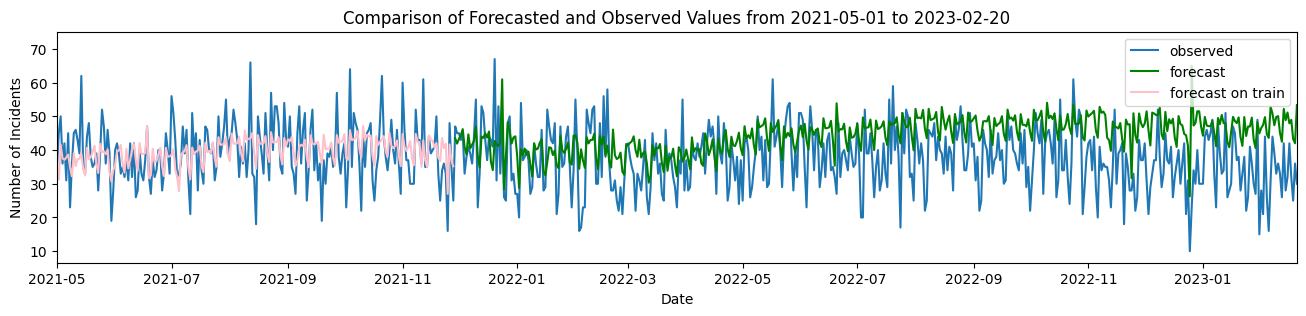

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
plt.plot(df.ds, df.y, label='observed')

plt.plot(forecast['ds'], forecast['yhat1'],
         label='forecast', color='green')
plt.plot(forecast_on_train['ds'], forecast_on_train['yhat1'],
         label='forecast on train', color='pink')
plt.title('Comparison of Forecasted and Observed Values from 2021-05-01 to ' + str(test.ds.iloc[-1])[:10])
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()

plt.xlim(pd.Timestamp('2021-05-01'), pd.Timestamp(test.ds.iloc[-1]))
plt.gcf().set_size_inches(16, 3)
plt.savefig('./neural-prophet-forecast.png')
plt.show()

4. Outputting final metrics for the model.

In [8]:

print('R2: ', r2_score(toTest['y'], toTest['yhat1']))
rmse = mean_squared_error(toTest['y'], toTest['yhat1'], squared=False)
print('RMSE: ', rmse)
print('RMSE on train: ', mean_squared_error(train['y'], forecast_on_train['yhat1'], squared=False))
print("MAPE: ", mean_absolute_percentage_error(toTest['y'], toTest['yhat1']))
print("MSE: ", mean_squared_error(toTest['y'], toTest['yhat1']))

R2:  -0.5530367492796602
RMSE:  11.317292497954647
RMSE on train:  7.327038744807922
MAPE:  0.30339348667642396
MSE:  128.0811094842605
